In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from sage.all import *

In [2]:
adjacency_list = [
    [19, 21, 3], 
    [23, 20, 4], 
    [24, 5, 1], 
    [6, 26, 2], 
    [27, 7, 3], 
    [29, 4, 8], 
    [5, 9, 30], 
    [32, 10, 6],
    [7, 33, 11],
    [35, 12, 8],
    [9, 36, 13],
    [38, 14, 10],
    [15, 39, 11],
    [12, 41, 16],
    [17, 42, 13],
    [18, 44, 14],
    [45, 15, 19],
    [20, 16, 47],
    [48, 1, 17],
    [2, 18, 50],
    [51, 22, 1],
    [21, 23, 37],
    [52, 2, 22],
    [53, 3, 25],
    [26, 40, 24],
    [4, 25, 54],
    [28, 55, 5],
    [43, 27, 29],
    [56, 6, 28],
    [57, 31, 7],
    [30, 32, 46],
    [31, 8, 58],
    [9, 34, 59],
    [49, 35, 33],
    [34, 60, 10],
    [37, 61, 11],
    [38, 36, 22],
    [62, 12, 37],
    [13, 63, 40],
    [25, 41, 39],
    [14, 64, 40],
    [65, 43, 15],
    [42, 28, 44],
    [16, 66, 43],
    [67, 17, 46],
    [31, 47, 45],
    [18, 68, 46],
    [69, 49, 19],
    [48, 34, 50],
    [20, 49, 70],
    [66, 21, 58],
    [65, 23, 57],
    [68, 60, 24],
    [59, 67, 26],
    [27, 62, 70],
    [61, 29, 69],
    [52, 30, 64],
    [63, 51, 32],
    [33, 66, 54],
    [35, 65, 53],
    [36, 68, 56],
    [55, 38, 67],
    [39, 58, 70],
    [69, 57, 41],
    [60, 42, 52],
    [44, 59, 51],
    [54, 45, 62],
    [61, 53, 47],
    [64, 48, 56],
    [50, 55, 63],
]

In [4]:
adjacency_matrix = [[0 for _ in range(70)] for _ in range(70)]
for i in range(70):
    for j in adjacency_list[i]:
        adjacency_matrix[i][j - 1] = 1

In [7]:
M = matrix(adjacency_matrix)

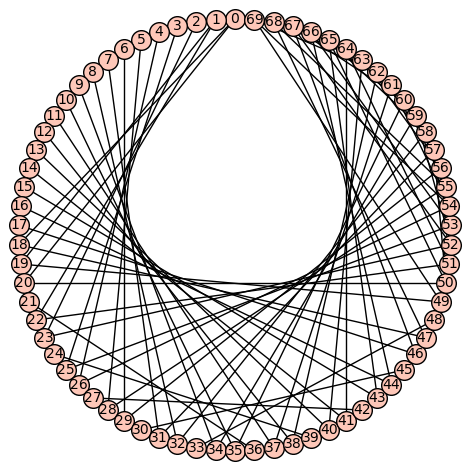

In [11]:
g = Graph(M, format='adjacency_matrix')
g.plot(layout='circular').show()

In [12]:
graphs.Balaban10Cage(embedding=2).is_isomorphic(g)

True

In [14]:
NUM_VERTICES = g.num_verts()
NUM_EDGES = g.size()
CYCLE_LENGTH = 10 # minimum cycle length
print(f"Number of vertices: {NUM_VERTICES}")
print(f"Number of edges: {NUM_EDGES}")

Number of vertices: 70
Number of edges: 105


In [18]:
adjacency_list = [[v for v in g.neighbors(u)] for u in range(NUM_VERTICES)]

In [13]:
cycles = [ c for c in g.to_directed().all_simple_cycles(max_length=17) if len(c) > CYCLE_LENGTH]

In [15]:
# sort cycles by ascending length
cycles.sort(key=lambda x: len(x))

In [16]:
cycles_by_vertex = [[] for _ in range(NUM_VERTICES)]
for i, c in enumerate(cycles):
    for v in c[:-1]:
        cycles_by_vertex[v].append(i)

In [20]:
from copy import deepcopy
VERTEX_USE_LIMIT = 3
max_used_cycles = 0

def x_in_y(query, base):
    try:
        l = len(query)
    except TypeError:
        l = 1
        query = type(base)((query,))

    for i in range(len(base)):
        if base[i:i+l] == query:
            return True
    return False

def ijkgood(c, solution):
    c = c.copy() + [c[1]]
    for i in range(len(c) - 2):
        for c2 in solution:
            c2 = c2.copy() + [c2[1]]
            if x_in_y([c[i + 2], c[i + 1], c[i]], c2):
                return False
    return True

def search(used_cycles, vertex_uses, adj_list) -> bool:
    TARGET = 2 * NUM_EDGES // CYCLE_LENGTH

    global max_used_cycles
    if len(used_cycles) > max_used_cycles:
        print(f"New max used cycles: {len(used_cycles)}:")
        max_used_cycles = len(used_cycles)
        for c in used_cycles:
            print([v + 1 for v in cycles[c]])
    
    # most used vertex not at limit
    m = list(filter(lambda x: x < VERTEX_USE_LIMIT, vertex_uses))
    if not m:
        return False
    vertex = vertex_uses.index(max(m))

    for i in cycles_by_vertex[vertex]:
        if i in used_cycles:
            continue

        cycle = cycles[i]

        edges_available = True
        for j in range(len(cycle) - 1):
            if cycle[j + 1] not in adj_list[cycle[j]]:
                edges_available = False
                break
        if not edges_available:
            continue

        if not ijkgood(cycle, [cycles[c] for c in used_cycles]):
            continue

        if len(used_cycles) == TARGET - 1:
            return True

        used_cycles_cpy = used_cycles.copy()
        used_cycles_cpy.add(i)

        adj_list_cpy = deepcopy(adj_list)
        for j in range(len(cycle) - 1):
            adj_list_cpy[cycle[j]].remove(cycle[j + 1])

        vertex_uses_cpy = vertex_uses.copy()
        for j in cycle[:-1]:
            vertex_uses_cpy[j] += 1

        if search(used_cycles_cpy, vertex_uses_cpy, adj_list_cpy):
            return True
    
    return False

for c in cycles[:528]:
    print("Trying cycle:", c)
    adj_list = deepcopy(adjacency_list)
    used_cycles = set()
    used_cycles.add(cycles.index(c))
    vertex_uses = [0] * NUM_VERTICES
    for v in c[:-1]:
        vertex_uses[v] = 1
    for i in range(len(c) - 1):
        adj_list[c[i]].remove(c[i + 1])

    if search(used_cycles, vertex_uses, adj_list):
        print("Found solution:")
        for c in used_cycles:
            print([v + 1 for v in cycles[c]])

Trying cycle: [0, 2, 4, 26, 27, 42, 41, 14, 16, 18, 0]
New max used cycles: 1:
[1, 3, 5, 27, 28, 43, 42, 15, 17, 19, 1]
New max used cycles: 2:
[1, 3, 5, 27, 28, 43, 42, 15, 17, 19, 1]
[1, 19, 48, 49, 34, 33, 59, 66, 51, 21, 1]
New max used cycles: 3:
[1, 3, 5, 27, 28, 43, 42, 15, 17, 19, 1]
[1, 19, 48, 49, 34, 33, 59, 66, 51, 21, 1]
[1, 21, 22, 37, 36, 61, 68, 53, 24, 3, 1]
New max used cycles: 4:
[1, 3, 5, 27, 28, 43, 42, 15, 17, 19, 1]
[1, 19, 48, 49, 34, 33, 59, 66, 51, 21, 1]
[1, 21, 22, 37, 36, 61, 68, 53, 24, 3, 1]
[3, 24, 25, 26, 54, 59, 33, 9, 7, 5, 3]
New max used cycles: 5:
[1, 3, 5, 27, 28, 43, 42, 15, 17, 19, 1]
[1, 21, 22, 37, 36, 61, 68, 53, 24, 3, 1]
[3, 24, 25, 26, 54, 59, 33, 9, 7, 5, 3]
[1, 19, 48, 49, 34, 33, 59, 66, 51, 21, 1]
[5, 7, 30, 31, 46, 45, 67, 62, 55, 27, 5]
New max used cycles: 6:
[1, 3, 5, 27, 28, 43, 42, 15, 17, 19, 1]
[1, 21, 22, 37, 36, 61, 68, 53, 24, 3, 1]
[3, 24, 25, 26, 54, 59, 33, 9, 7, 5, 3]
[1, 19, 48, 49, 34, 33, 59, 66, 51, 21, 1]
[7, 9, 11,

KeyboardInterrupt: 